# Post-process interactions data

## Hydrogen bonds

Gather all data for low-RMSD trajectories

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dirnames = !ls -d data/cWza*_conformation*_[0-9][0-9][0-9][0-9]

In [3]:
HBA_data = {}
for outdir in dirnames:
    model_name = outdir.split('/')[-1]

    with open(os.path.join(outdir, "md_100ns.hbonds.pickle"),'rb') as fp:
        X = pickle.load(fp)
        
    HBA_data[model_name] = {k:X[k]['time'] for k,v in X.items()}

### All H-bond counts

Visualise all counts regardless of model identity

In [4]:
df = pd.DataFrame.from_dict({model_name: {hbond: np.sum(HBA_data[model_name][hbond])/1000 for hbond in HBA_data[model_name].keys()} for model_name in HBA_data.keys()})

In [5]:
df = df.fillna(0)
hbonds_sorted = sorted(df.index, key=lambda hbond:sum(df.loc[hbond]), reverse=True)
df = df.reindex(hbonds_sorted)

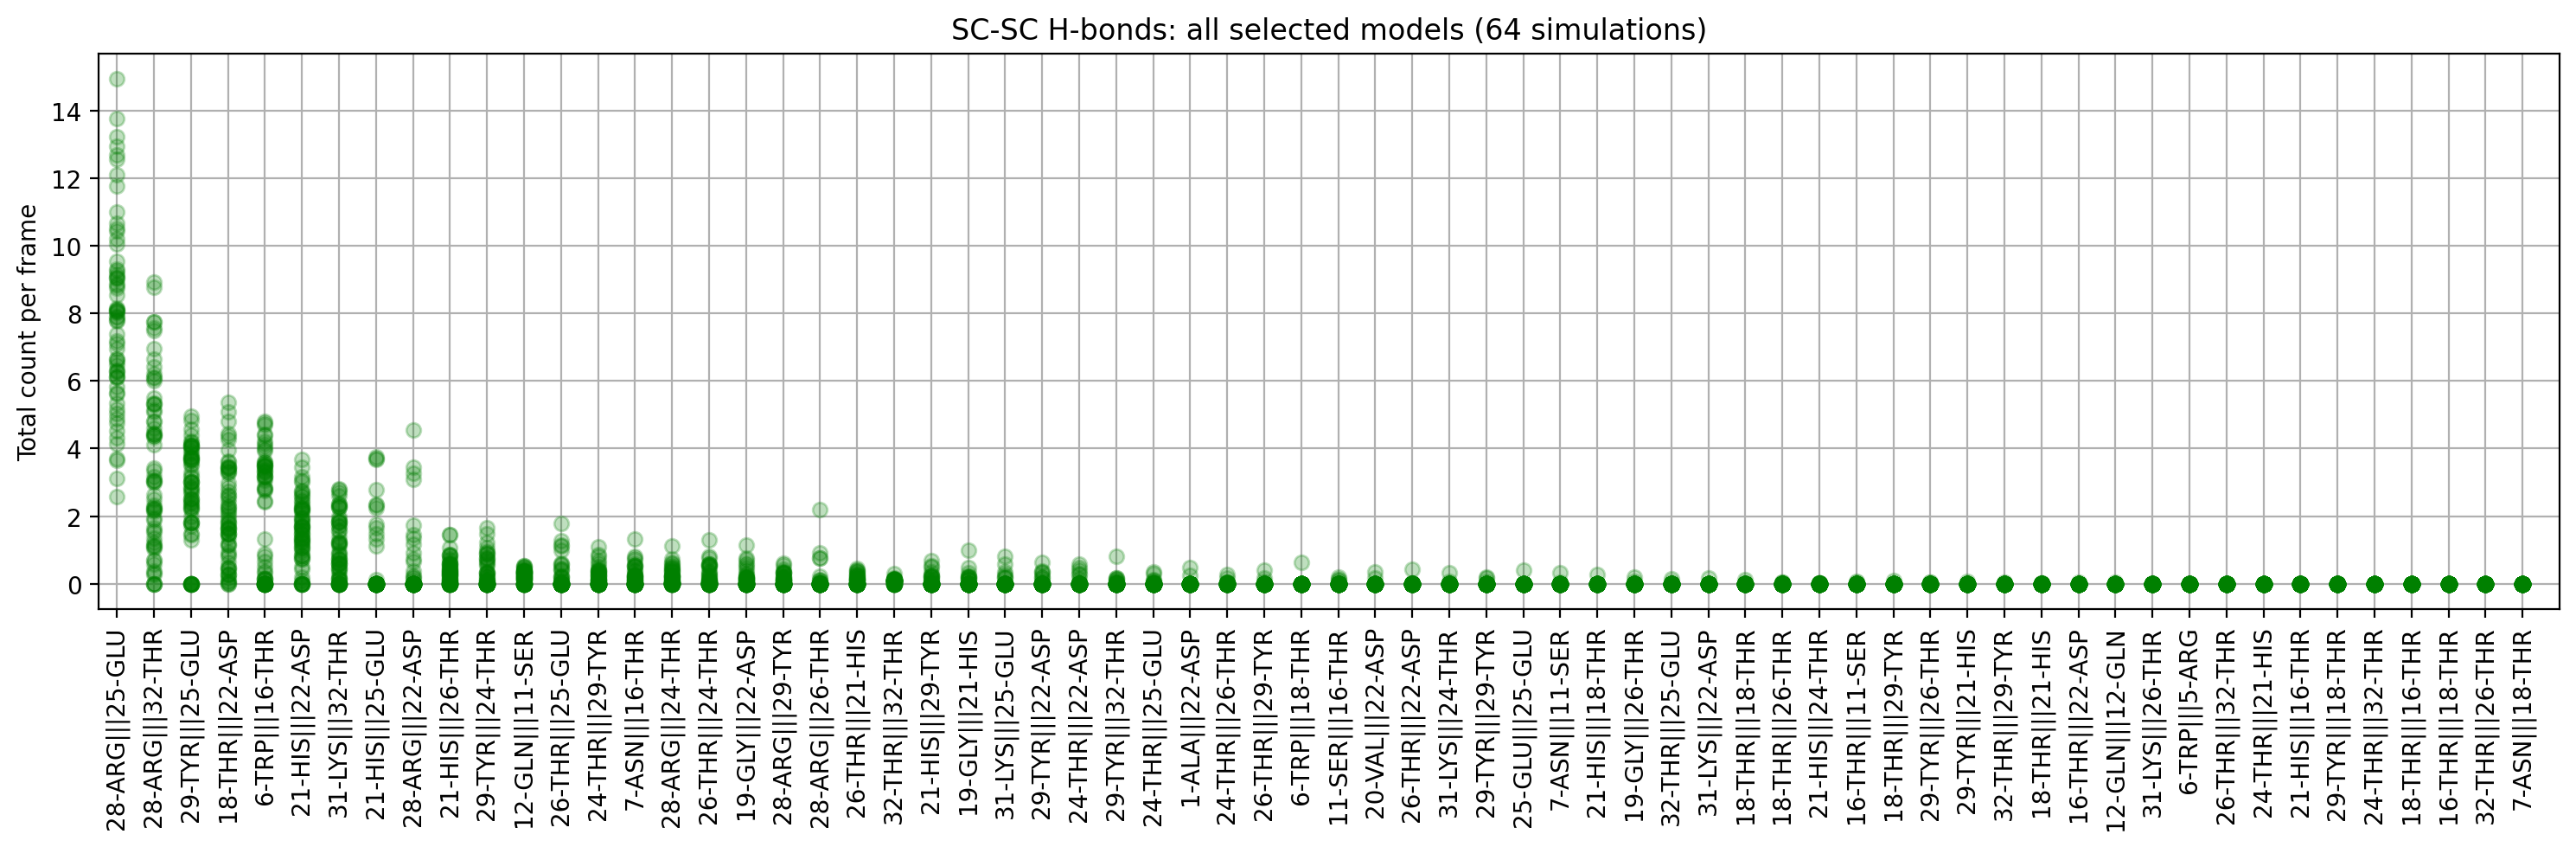

In [6]:
fig,ax = plt.subplots(1,1,figsize=(15,5),dpi=200)

df.plot(marker='o',color='green',linestyle='',alpha=0.25, ax=ax)

ax.set_xticks(range(len(df.index)))
hbonds_labels = [x[0]+'|||'+x[1] for x in df.index]
ax.set_xticklabels(hbonds_labels, rotation=90)

ax.set_xlim(-0.5,len(df.index))
ax.set_ylabel('Total count per frame')
ax.set_title('SC-SC H-bonds: all selected models (64 simulations)')

ax.grid(True)
legend = ax.legend()
legend.remove()
fig.tight_layout()

plt.show()

Visualise all counts considering model identity

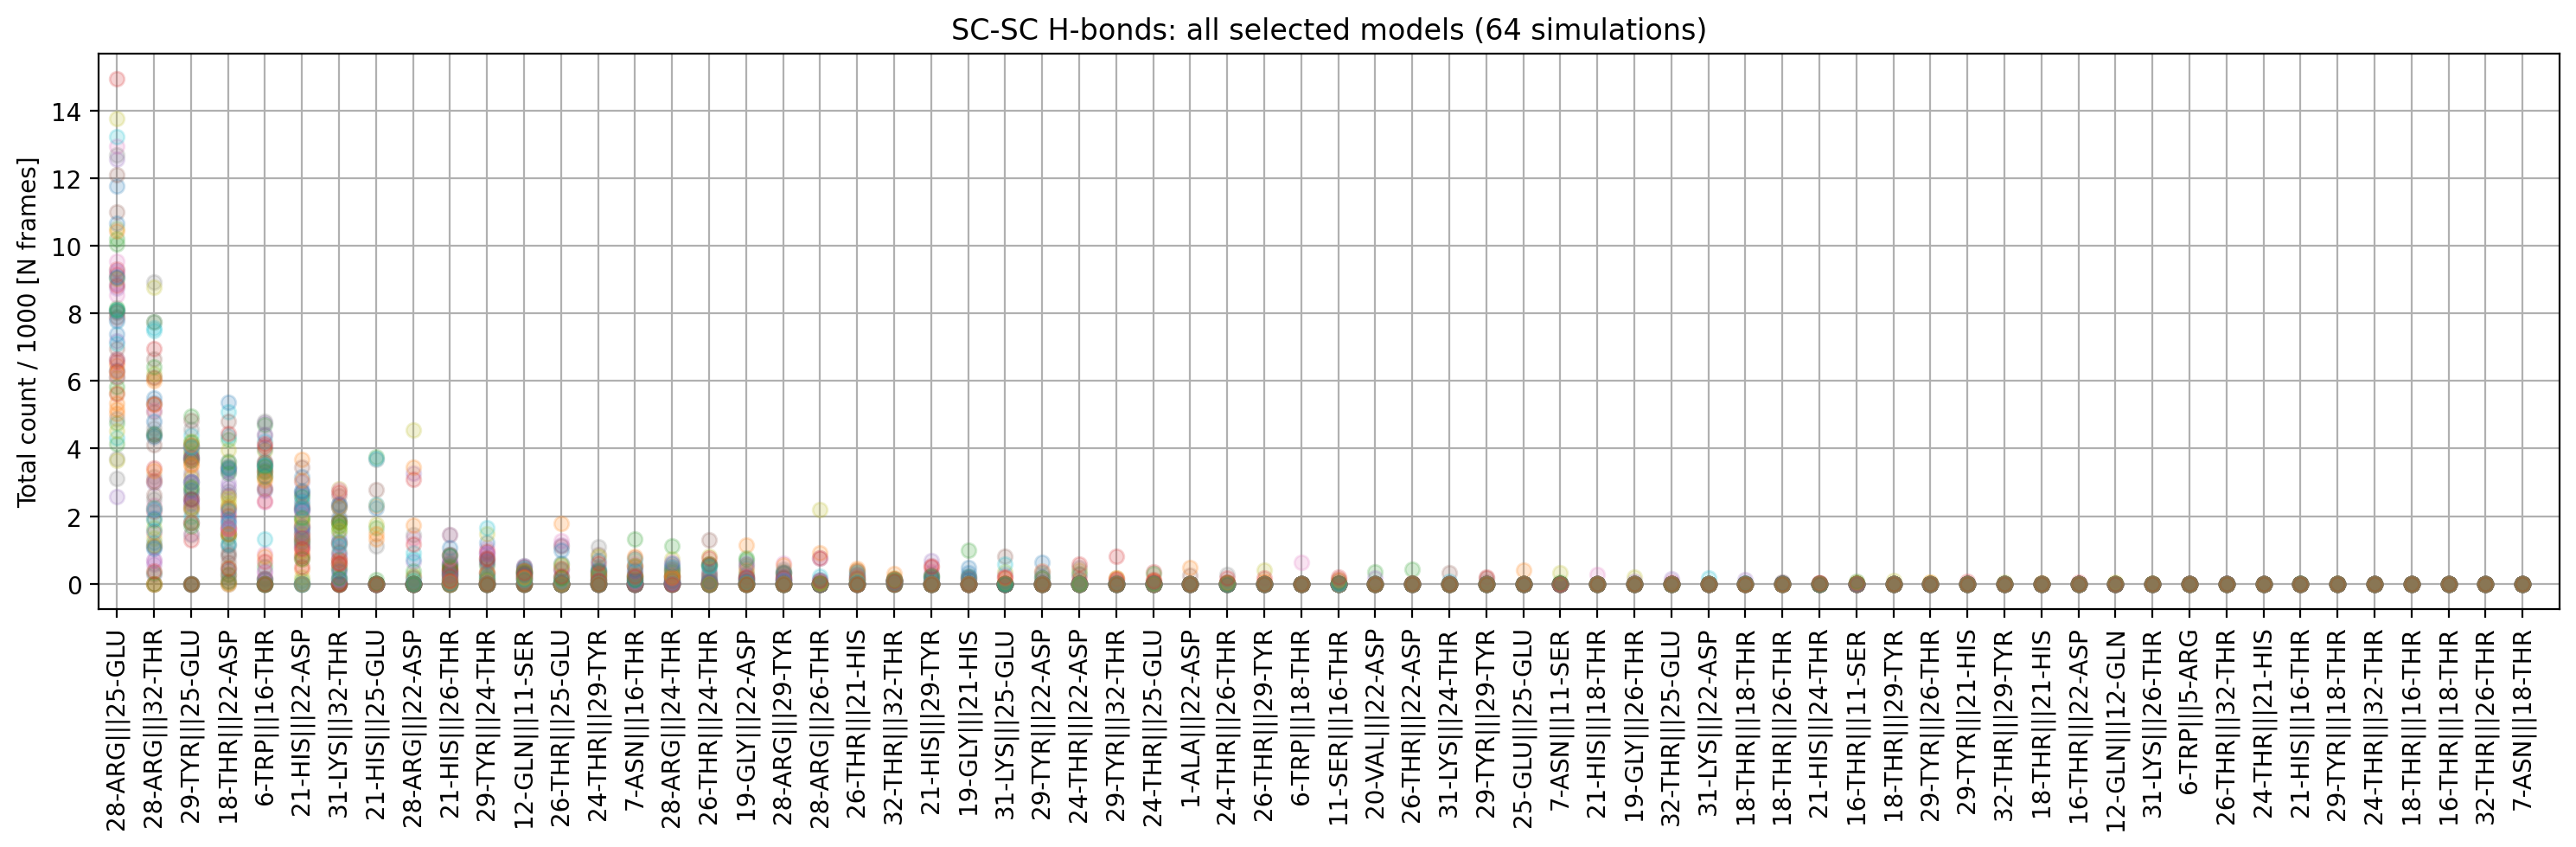

In [7]:
fig,ax = plt.subplots(1,1,figsize=(15,5),dpi=200)

df.plot(marker='o',linestyle='',alpha=0.2, ax=ax)

ax.set_xticks(range(len(df.index)))
hbonds_labels = [x[0]+'|||'+x[1] for x in df.index]
ax.set_xticklabels(hbonds_labels, rotation=90)

ax.set_xlim(-0.5,len(df.index))
ax.set_ylabel('Total count / 1000 [N frames]')
ax.set_title('SC-SC H-bonds: all selected models (64 simulations)')

ax.grid(True)
legend = ax.legend()
legend.remove()
fig.tight_layout()

plt.show()

### Dominant H-bonds

In [8]:
keep_hbonds = [max(df.loc[hbonds]) > 2 for hbonds in df.index]
df_trimmed = df[keep_hbonds]

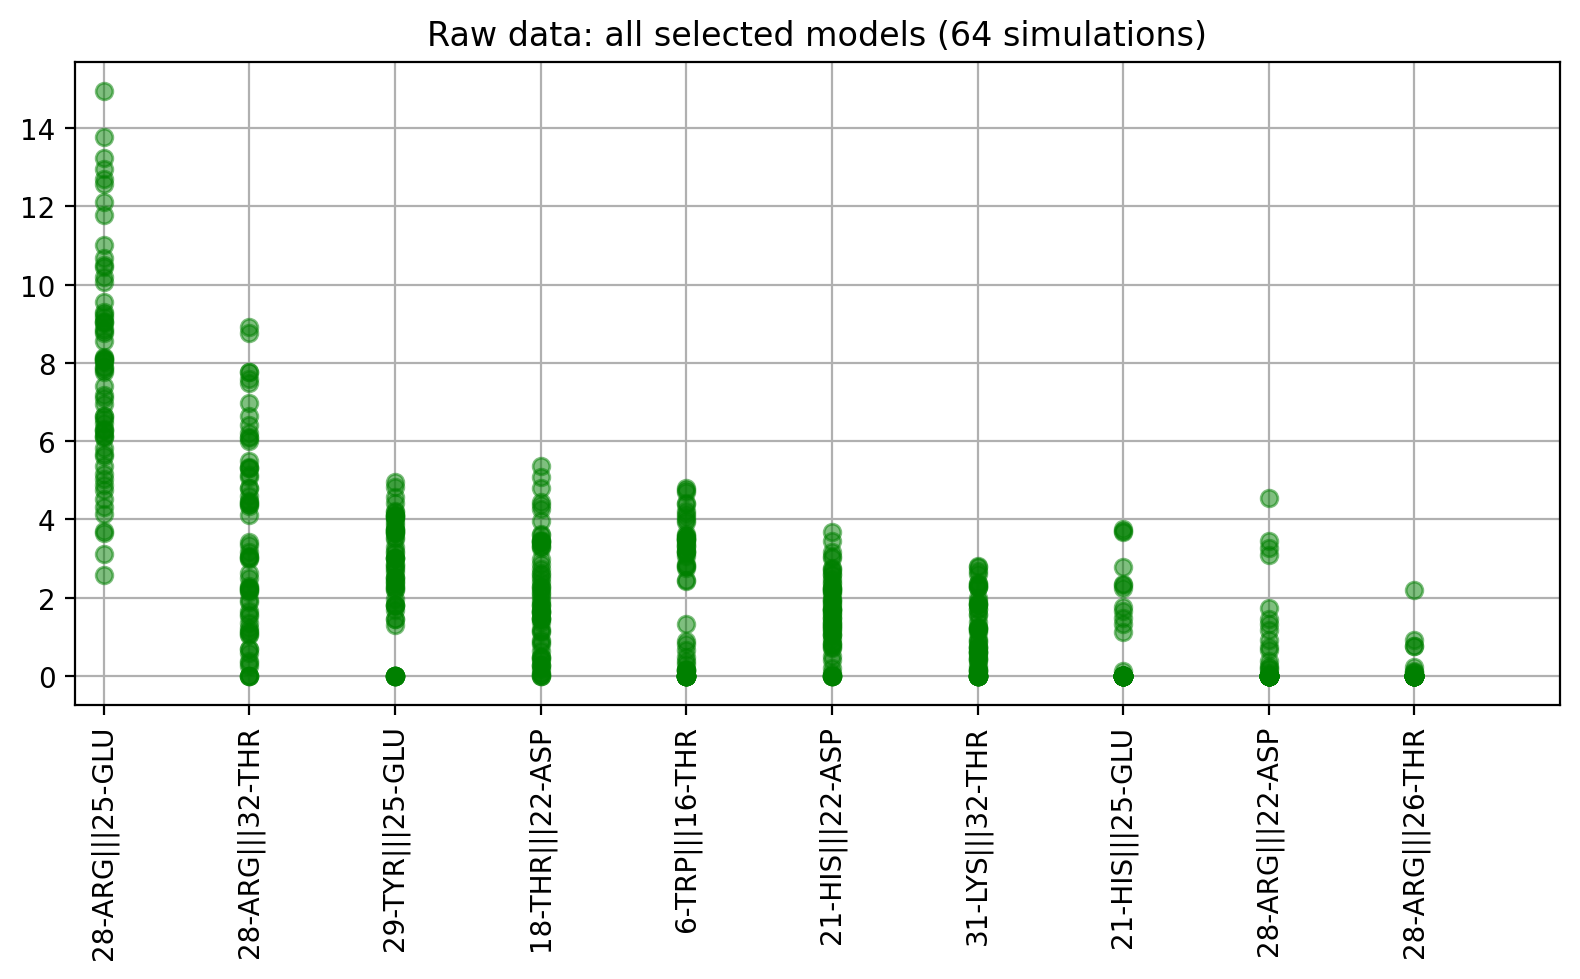

In [10]:
fig,ax = plt.subplots(1,1,figsize=(8,5),dpi=200)

df_trimmed.plot(marker='o',linestyle='',color='green',alpha=0.5, ax=ax)

ax.set_xticks(range(len(df_trimmed.index)))
hbonds_labels = [x[0]+'|||'+x[1] for x in df_trimmed.index]
ax.set_xticklabels(hbonds_labels, rotation=90)
ax.set_title('Raw data: all selected models (64 simulations)')

ax.set_xlim(-0.2,len(df_trimmed.index))
ax.grid(True)
legend = ax.legend()
legend.remove()


fig.tight_layout()
plt.show()

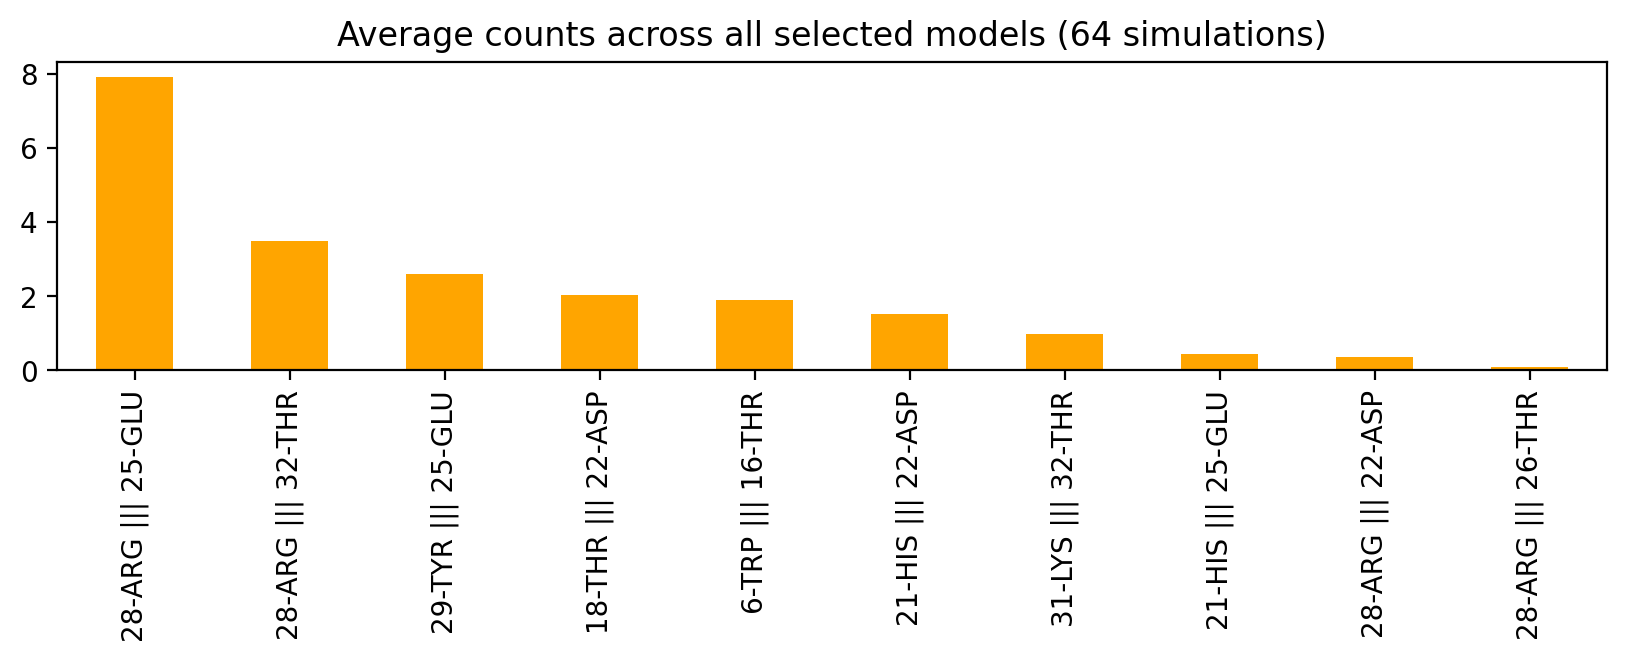

In [12]:
import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=(10,2),dpi=200)

data = df_trimmed.mean(axis=1)
data.plot(kind='bar',color='orange',ax=ax)

ax.set_xticks(range(len(data.index)))
hbonds_labels = [x[0]+' ||| '+x[1] for x in data.index]
ax.set_xticklabels(hbonds_labels, rotation=90)
ax.set_title('Average counts across all selected models (64 simulations)')

plt.show()

In [59]:
df_trimmed.to_pickle('data/df_md_dominant_hbonds.pickle')

## Noncovalent contacts

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_original_chain(x, peptide_length = 32):
    N = peptide_length
    if x%N == 0:
        return x//N -1
    else:
        return x//N

def get_original_resnum(x, peptide_length = 32):
    N = peptide_length
    if x%N == 0:
        return N
    else:
        return x%N

In [2]:
dirnames = !ls -d data/cWza*_conformation*_[0-9][0-9][0-9][0-9]

In [3]:
NCC_data = {}
for outdir in dirnames:
    model_name = outdir.split('/')[-1]
    
    with open(os.path.join(outdir, "md_100ns.contacts.pickle"),'rb') as fp:
        X = pickle.load(fp)
        
    contacts_data = {k:X[k] for k,v in X.items()}
    
    # Group timeseries for same residue pairs across chains
    contacts_grouped = {}
    for key in contacts_data.keys():
        i, j = key
        key_new = (get_original_resnum(i), get_original_resnum(j))
        try:
            contacts_grouped[key_new].append(contacts_data[key])
        except KeyError:
            contacts_grouped[key_new] = []

    # Sum over all contact timeseries
    contatcs_nonredundant = {k:sum(v) for k,v in contacts_grouped.items() if (len(v)>1)}

    NCC_data[model_name] = contatcs_nonredundant

In [4]:
X = NCC_data
n_frames = 1001

# Average contacts per frame 
df = pd.DataFrame.from_dict({model_name: {respair: np.sum(X[model_name][respair])/n_frames for respair in X[model_name].keys()} for model_name in X.keys()})

df = df.fillna(0)
respairs_sorted = sorted(df.index, key=lambda respair:sum(df.loc[respair]), reverse=True)
df = df.reindex(respairs_sorted)

df.shape

(242, 64)

### All conctact counts

In [5]:
# Filtering condition: soft-condition
# Keep residue-pair if there is at least one model whose contacts are above the threshold
threshold = 10
keep_respairs = [any(df.loc[respairs] > threshold) for respairs in df.index]
df_trimmed = df[keep_respairs]

df_trimmed.shape

(65, 64)

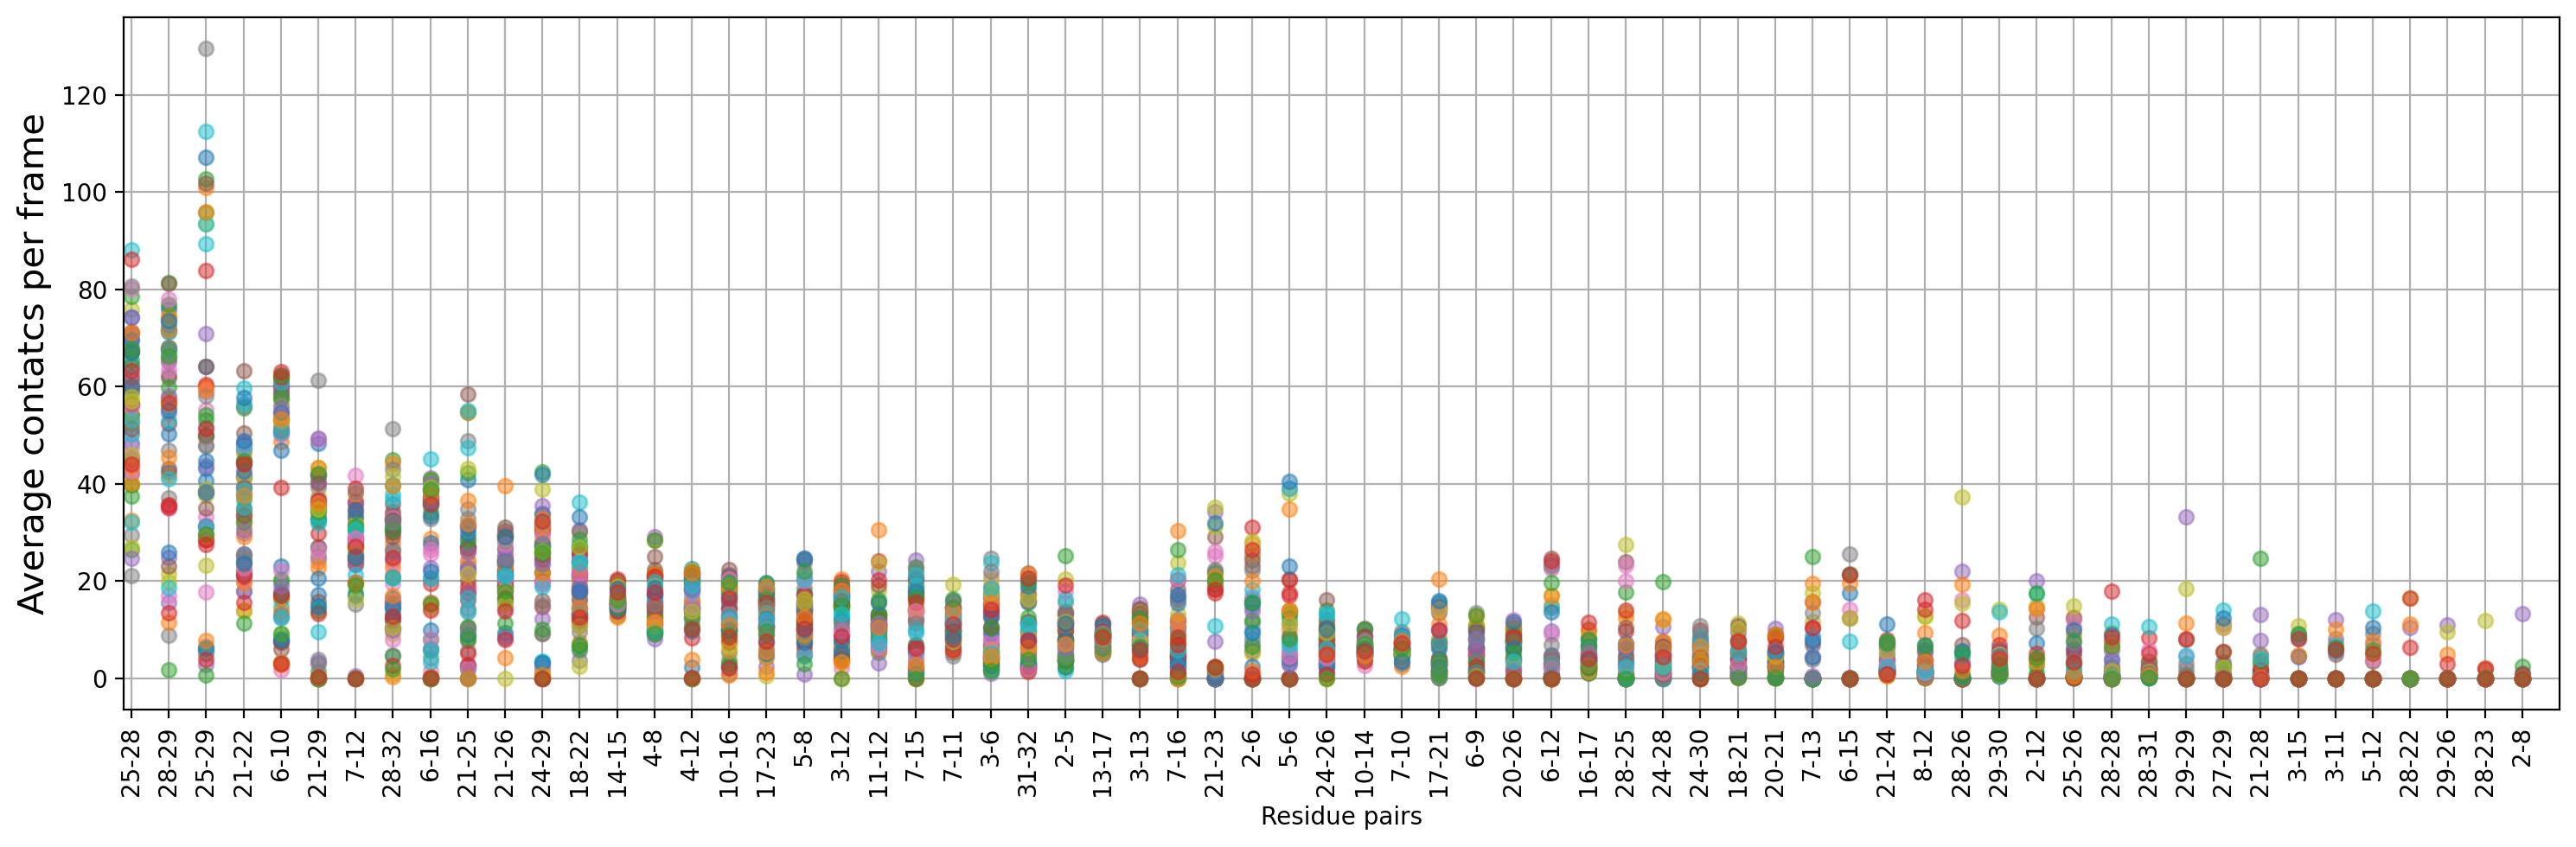

In [6]:
fig,ax = plt.subplots(1,1,figsize=(15,5),dpi=200)

df_trimmed.plot(marker='o',linestyle='',alpha=0.5, ax=ax)

ax.set_xticks(range(len(df_trimmed.index)))
respairs_labels = [str(x[0])+'-'+str(x[1]) for x in df_trimmed.index]
ax.set_xticklabels(respairs_labels,fontsize=10,rotation=90)

ax.set_xlim(-0.2,len(df_trimmed.index))
ax.grid(True)
legend = ax.legend()
legend.remove()

ax.set_xlabel('Residue pairs', fontsize=10)
ax.set_ylabel('Average contatcs per frame', fontsize=15)
ax.set_title('')

fig.tight_layout()
plt.show()

### Dominant Noncovalent contacts

In [7]:
# Filtering condition: mild-condition
# Keep residue-pair if certain fraction of the model's contacts are above the threshold
threshold = 10
fraction = 0.80 # 80% 
keep_respairs = [sum(df.loc[respairs] > threshold)/len(df.columns) >= fraction for respairs in df.index]
df_trimmed = df[keep_respairs]

df_trimmed.shape

(10, 64)

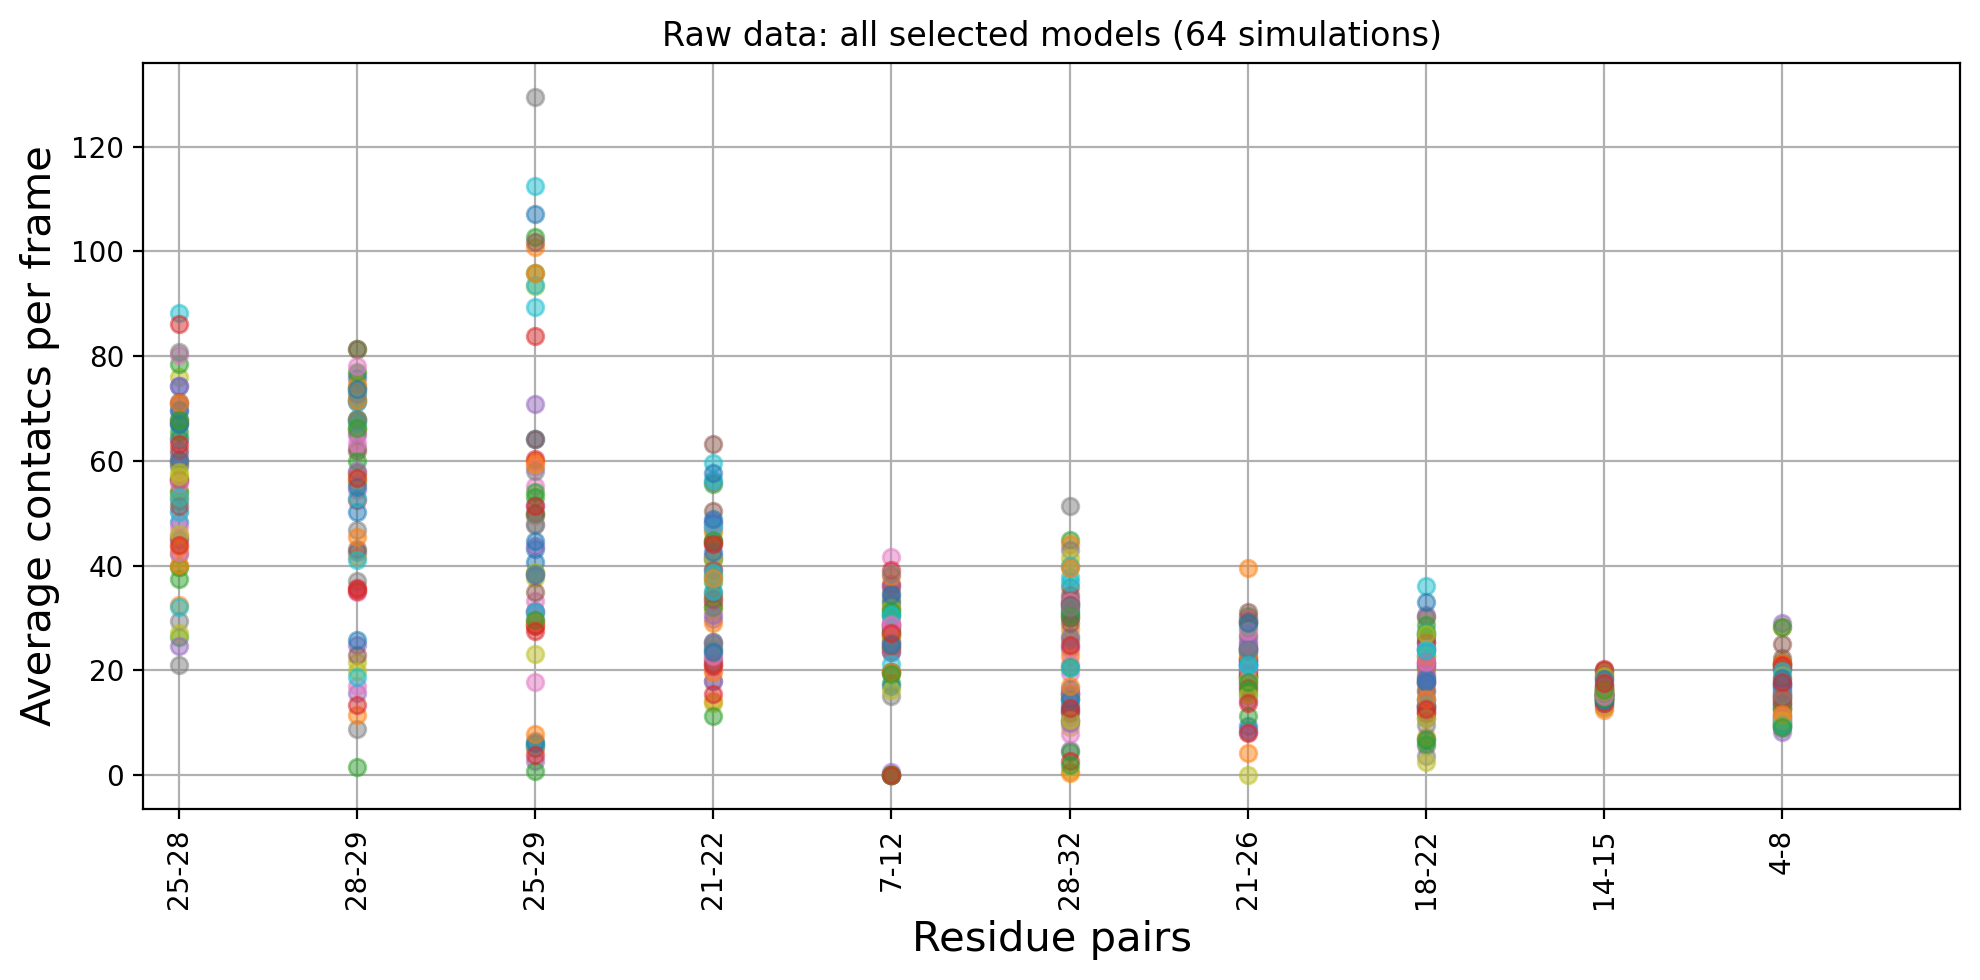

In [8]:
fig,ax = plt.subplots(1,1,figsize=(10,5),dpi=200)

df_trimmed.plot(marker='o',linestyle='',alpha=0.5, ax=ax)

ax.set_xticks(range(len(df_trimmed.index)))
respairs_labels = [str(x[0])+'-'+str(x[1]) for x in df_trimmed.index]
ax.set_xticklabels(respairs_labels,fontsize=10,rotation=90)


ax.set_xlim(-0.2,len(df_trimmed.index))
ax.grid(True)
legend = ax.legend()
legend.remove()

ax.set_xlabel('Residue pairs', fontsize=15)
ax.set_ylabel('Average contatcs per frame', fontsize=15)
ax.set_title('Raw data: all selected models (64 simulations)')

fig.tight_layout()
plt.show()

Fix labels for residue contact pairs

In [9]:
df_trimmed2 = pd.DataFrame(df_trimmed.values, 
                           columns = df_trimmed.columns,
                           index=[json.dumps(x) for x in list(df_trimmed.index)])

In [10]:
df_trimmed2.T

,"[25, 28]","[28, 29]","[25, 29]","[21, 22]","[7, 12]","[28, 32]","[21, 26]","[18, 22]","[14, 15]","[4, 8]"
cWza_conformation0_0188,48.313686,42.507493,64.216783,41.290709,24.468531,31.244755,20.811189,20.823177,14.615385,21.008991
cWza_conformation0_0227,54.247752,67.705295,60.012987,38.042957,25.726274,27.924076,22.305694,30.194805,14.661339,28.343656
cWza_conformation0_0231,26.377622,71.738262,95.894106,41.594406,17.546454,44.881119,30.318681,14.452547,15.508492,8.913087
cWza_conformation0_0433,45.274725,57.620380,60.408591,44.665335,27.572428,30.013986,23.989011,16.328671,16.716284,21.124875
cWza_conformation0_0553,60.165834,67.555445,51.612388,39.415584,33.692308,33.553447,20.737263,30.478521,15.264735,29.015984
...,...,...,...,...,...,...,...,...,...,...
cWza-Y373C_conformation1_0504,88.232767,18.648352,5.776224,35.082917,21.263736,20.479520,21.044955,23.802198,15.974026,9.504496
cWza-Y373C_conformation1_0560,69.682318,25.844156,6.111888,23.513487,25.068931,14.457542,29.032967,17.747253,18.377622,18.620380
cWza-Y373C_conformation1_0646,71.023976,11.538462,7.812188,37.661339,19.687313,16.949051,39.514486,14.504496,16.112887,11.620380
cWza-Y373C_conformation1_0826,67.734266,1.609391,0.693307,11.354645,19.200799,1.910090,17.812188,6.849151,16.158841,9.201798


In [11]:
df_dominant_contacts = df_trimmed2

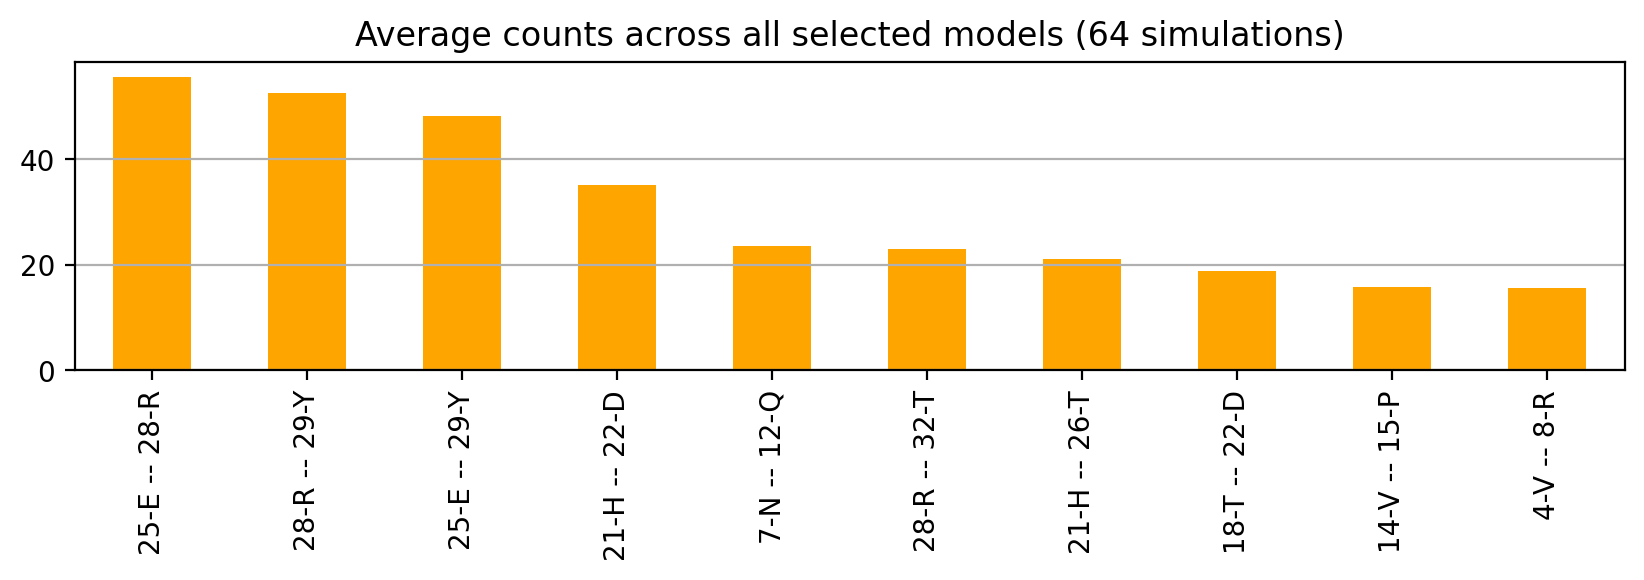

In [19]:
import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=(10,2),dpi=200)

data = df_dominant_contacts.mean(axis=1)
data.plot(kind='bar',color='orange',ax=ax)

ax.set_xticks(range(len(data.index)))

contacts_labels = []
f = lambda x:tuple(json.loads(x))
seq = 'APLVRWNRVISQLVPTITGVHDLTETVRYIKTWPN'
for contact in data.index:
    contact = f(contact)
    resn_A = contact[0]
    resn_B = contact[1]
    label = str(resn_A)+'-'+seq[resn_A-1]+' -- '+str(resn_B)+'-'+seq[resn_B-1]
    contacts_labels.append(label)

ax.set_xticklabels(contacts_labels, rotation=90)
ax.set_title('Average counts across all selected models (64 simulations)')

ax.yaxis.grid(True)
plt.show()

In [37]:
df_trimmed2.to_csv('data/df_md_dominant_contacts.csv', index_label=False)

# Barplots: Trajectories sorted Interactions by average counts

## Hydrogen bonds

In [108]:
hbonds_leads =  [('28-ARG', '25-GLU'),
                 ('28-ARG', '32-THR'),
                 ('29-TYR', '25-GLU'),
                 ('18-THR', '22-ASP'),
                 ('6-TRP', '16-THR'),
                 ('21-HIS', '22-ASP'),
                 ('31-LYS', '32-THR'),
                 ('21-HIS', '25-GLU'),
                 ('28-ARG', '22-ASP'),
                 ('28-ARG', '26-THR')]

In [192]:
mutant_colors = {'cWza':'lightblue',
                 'cWza-S355C':'khaki',
                 'cWza-K375C':'lightgrey',
                 'cWza-Y373C': 'blueviolet'}

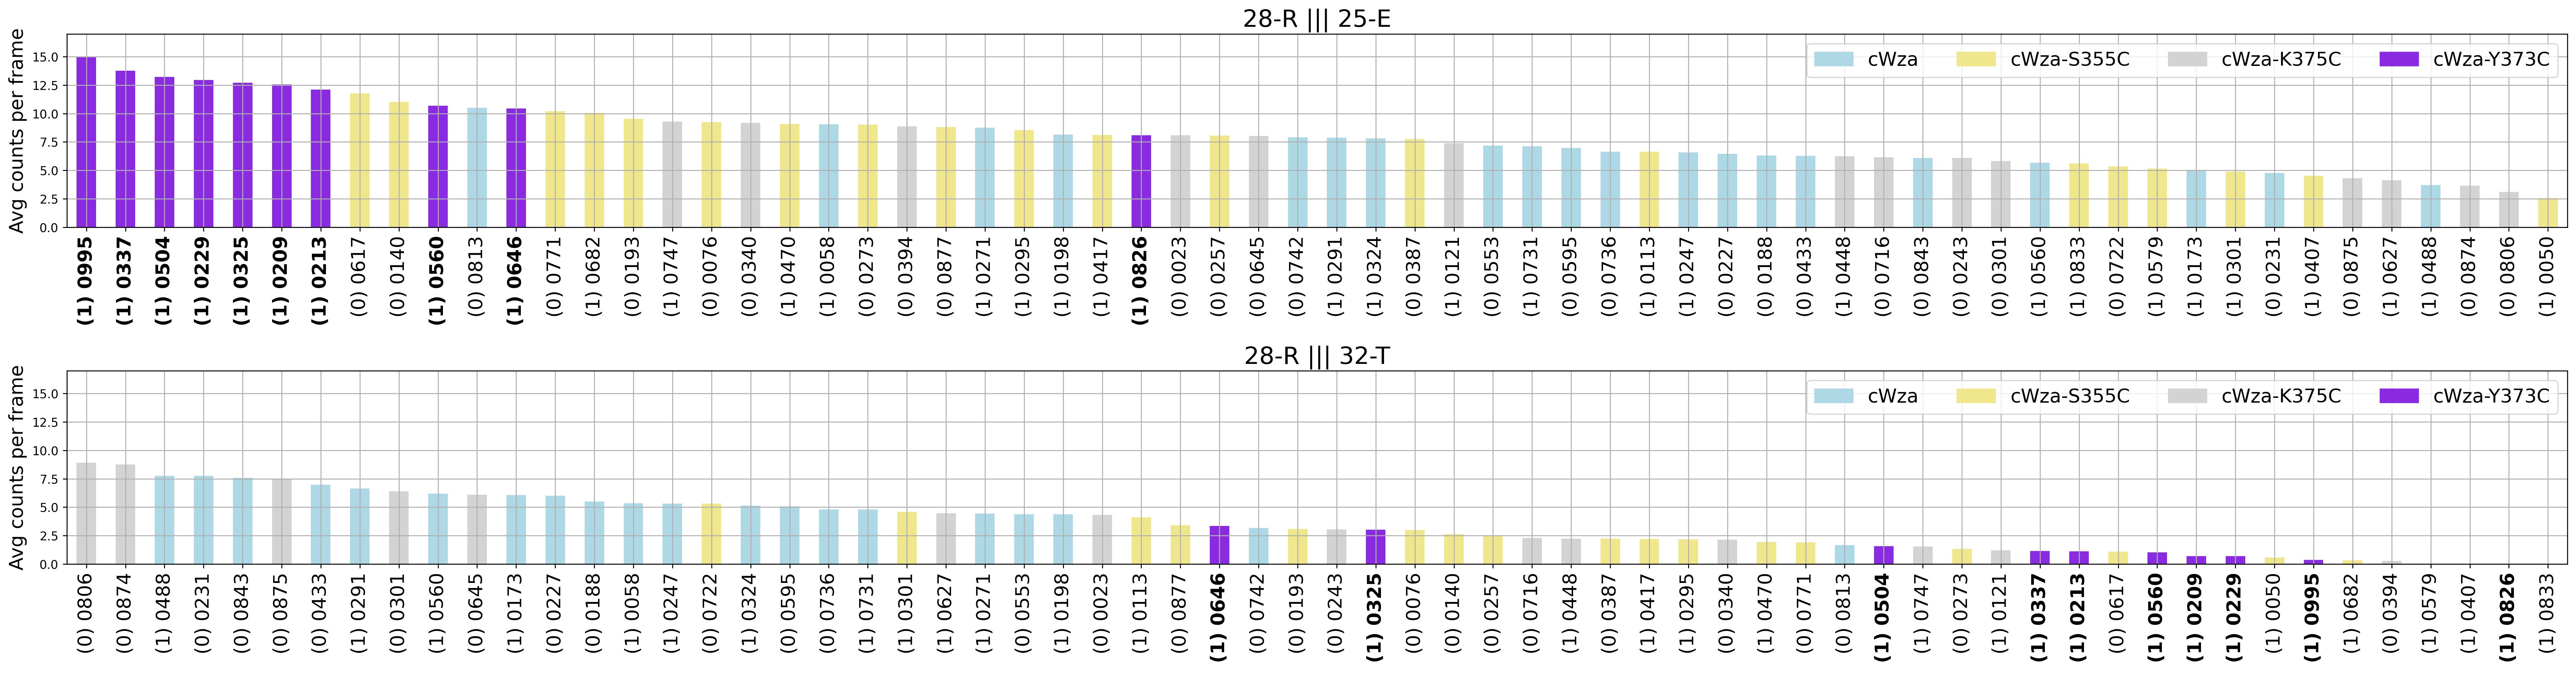

In [206]:
fig, axes = plt.subplots(2,1, figsize=(30,8),sharey=True,dpi=200)

################################################
ax = axes[0]
df_sorted = df_trimmed.T[hbonds_leads[0]].sort_values(ascending=False)

models_names = list(df_sorted.index)
labels = []
colors = []
for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    y = ' ('+conformation[-1]+') '+number
    labels.append(y)
    colors.append(mutant_colors[mutant])
    
df_sorted.plot(kind='bar', stacked=True, color=colors, ax=ax)

ax.set_xticklabels(labels, fontsize=16)

for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    if mutant == 'cWza-Y373C':
        ax.get_xticklabels()[i].set_weight("bold")
        
ax.set_ylim(0,17)

x = hbonds_leads[0]
donor_resn, donor_resname = x[0].split("-")
acceptor_resn, acceptor_resname = x[1].split("-")
title = donor_resn+'-'+aa_3to1[donor_resname]+' ||| '+acceptor_resn+'-'+aa_3to1[acceptor_resname]
ax.set_title(title, fontsize=20)

ax.set_ylabel('Avg counts per frame',fontsize=16)

import matplotlib.patches as mpatches
patches = []
for m in mutant_colors.keys():
    p = mpatches.Patch(color=mutant_colors[m], label=m)
    patches.append(p)
ax.legend(loc='upper right', 
          ncol=len(mutant_colors.keys()),
          handles=patches,
          fontsize=16)

ax.grid(True)

################################################
ax = axes[1]
df_sorted = df_trimmed.T[hbonds_leads[1]].sort_values(ascending=False)

models_names = list(df_sorted.index)
labels = []
colors = []
for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    y = ' ('+conformation[-1]+') '+number
    labels.append(y)
    colors.append(mutant_colors[mutant])
        
df_sorted.plot(kind='bar', stacked=True, color=colors, ax=ax)
ax.set_xticklabels(labels, fontsize=16)

for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    if mutant == 'cWza-Y373C':
        ax.get_xticklabels()[i].set_weight("bold")

ax.set_ylim(0,17)

x = hbonds_leads[1]
donor_resn, donor_resname = x[0].split("-")
acceptor_resn, acceptor_resname = x[1].split("-")
title = donor_resn+'-'+aa_3to1[donor_resname]+' ||| '+acceptor_resn+'-'+aa_3to1[acceptor_resname]
ax.set_title(title, fontsize=20)

ax.set_ylabel('Avg counts per frame',fontsize=16)

import matplotlib.patches as mpatches
patches = []
for m in mutant_colors.keys():
    p = mpatches.Patch(color=mutant_colors[m], label=m)
    patches.append(p)
ax.legend(loc='upper right', 
          ncol=len(mutant_colors.keys()),
          handles=patches,
          fontsize=16)

ax.grid(True)

################################################
fig.tight_layout()
plt.show()

## Noncovalent contacts

In [18]:
df_md_dominant_contacts = pd.read_csv('data/df_md_dominant_contacts.csv')
contacts_leads = list(df_md_dominant_contacts.index)

In [15]:
mutant_colors = {'cWza':'lightblue',
                 'cWza-S355C':'khaki',
                 'cWza-K375C':'lightgrey',
                 'cWza-Y373C': 'blueviolet'}

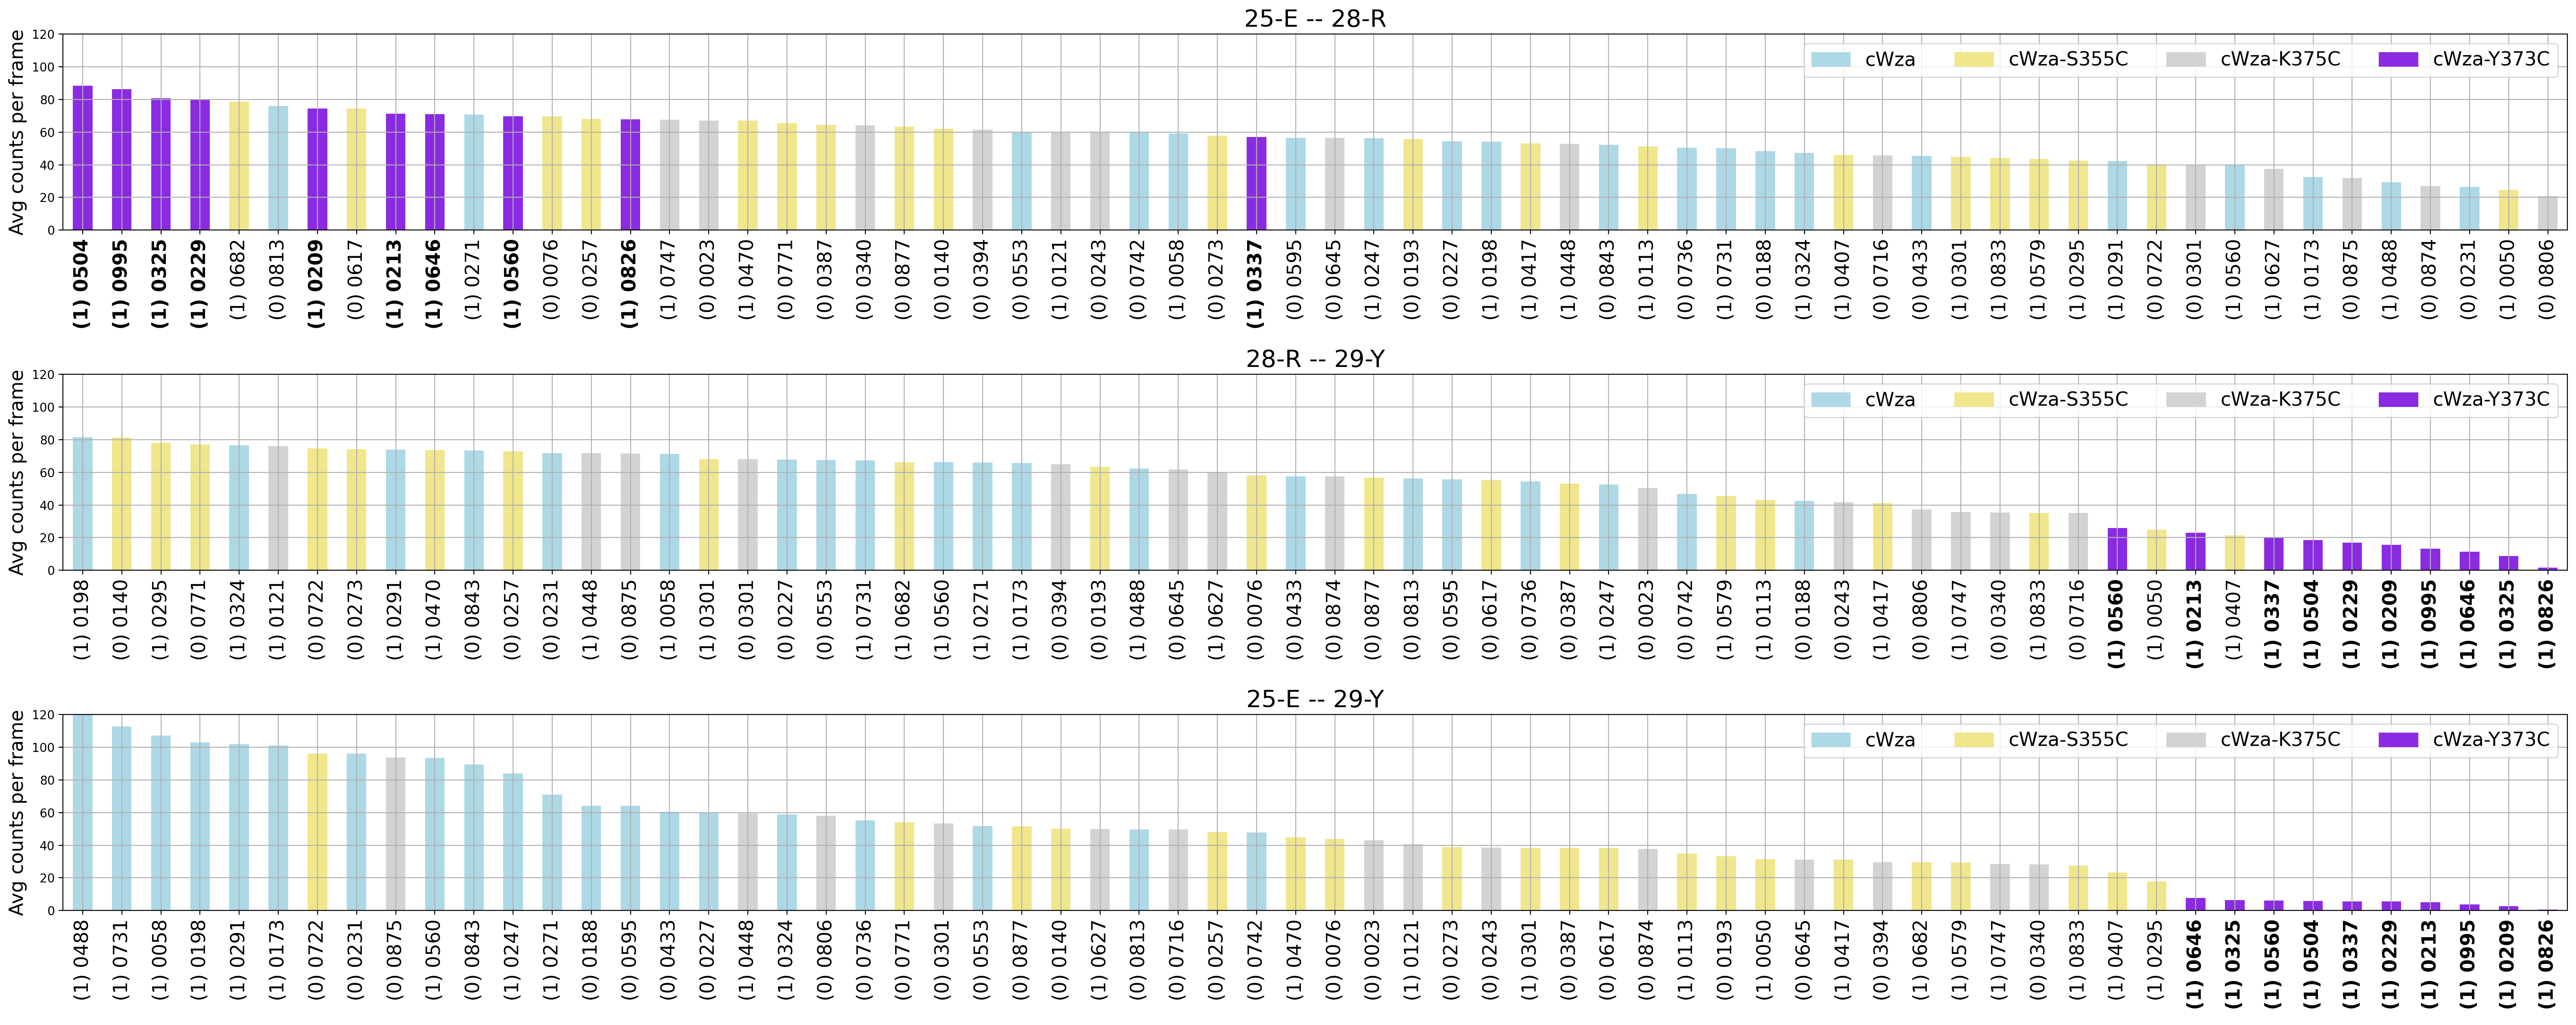

In [16]:
fig, axes = plt.subplots(3,1, figsize=(30,12),sharey=True,dpi=200)

################################################
ax = axes[0]

df_sorted = df_md_dominant_contacts.T[contacts_leads[0]].sort_values(ascending=False)

seq = 'APLVRWNRVISQLVPTITGVHDLTETVRYIKTWPN'

models_names = list(df_sorted.index)
labels = []
colors = []
for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    y = ' ('+conformation[-1]+') '+number
    labels.append(y)
    colors.append(mutant_colors[mutant])
    
df_sorted.plot(kind='bar', stacked=True, color=colors, ax=ax)
ax.set_xticklabels(labels, fontsize=16)

for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    if mutant == 'cWza-Y373C':
        ax.get_xticklabels()[i].set_weight("bold")

ax.set_ylabel('Avg Contacts per frame',fontsize=16)
ax.set_ylim(0,120)

x = contacts_leads[0]
resn_A = json.loads(x)[0]
resn_B = json.loads(x)[1]
title = str(resn_A)+'-'+seq[resn_A-1]+' -- '+str(resn_B)+'-'+seq[resn_B-1]
ax.set_title(title, fontsize=20)

ax.set_ylabel('Avg counts per frame',fontsize=16)

import matplotlib.patches as mpatches
patches = []
for m in mutant_colors.keys():
    p = mpatches.Patch(color=mutant_colors[m], label=m)
    patches.append(p)
ax.legend(loc='upper right', 
          ncol=len(mutant_colors.keys()),
          handles=patches,
          fontsize=16)

ax.grid(True)
################################################
ax = axes[1]

df_sorted = df_md_dominant_contacts.T[contacts_leads[1]].sort_values(ascending=False)
#df_sorted.plot(kind='bar', stacked=True, color='orange', ax=ax)

seq = 'APLVRWNRVISQLVPTITGVHDLTETVRYIKTWPN'

models_names = list(df_sorted.index)
labels = []
colors = []
for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    y = ' ('+conformation[-1]+') '+number
    labels.append(y)
    colors.append(mutant_colors[mutant])
    
df_sorted.plot(kind='bar', stacked=True, color=colors, ax=ax)
ax.set_xticklabels(labels, fontsize=16)

for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    if mutant == 'cWza-Y373C':
        ax.get_xticklabels()[i].set_weight("bold")

ax.set_ylabel('Avg Contacts per frame',fontsize=16)
ax.set_ylim(0,120)

x = contacts_leads[1]
resn_A = json.loads(x)[0]
resn_B = json.loads(x)[1]
title = str(resn_A)+'-'+seq[resn_A-1]+' -- '+str(resn_B)+'-'+seq[resn_B-1]
ax.set_title(title, fontsize=20)

ax.set_ylabel('Avg counts per frame',fontsize=16)

import matplotlib.patches as mpatches
patches = []
for m in mutant_colors.keys():
    p = mpatches.Patch(color=mutant_colors[m], label=m)
    patches.append(p)
ax.legend(loc='upper right', 
          ncol=len(mutant_colors.keys()),
          handles=patches,
          fontsize=16)

ax.grid(True)

################################################
ax = axes[2]

df_sorted = df_md_dominant_contacts.T[contacts_leads[2]].sort_values(ascending=False)
df_sorted.plot(kind='bar', stacked=True, color='orange', ax=ax)

seq = 'APLVRWNRVISQLVPTITGVHDLTETVRYIKTWPN'

models_names = list(df_sorted.index)
labels = []
colors = []
for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    y = ' ('+conformation[-1]+') '+number
    labels.append(y)
    colors.append(mutant_colors[mutant])
    
df_sorted.plot(kind='bar', stacked=True, color=colors, ax=ax)
ax.set_xticklabels(labels, fontsize=16)

for i, x in enumerate(models_names):
    mutant, conformation, number = x.split('_')
    if mutant == 'cWza-Y373C':
        ax.get_xticklabels()[i].set_weight("bold")
        
ax.set_ylabel('Avg Contacts per frame',fontsize=16)
ax.set_ylim(0,120)

x = contacts_leads[2]
resn_A = json.loads(x)[0]
resn_B = json.loads(x)[1]
title = str(resn_A)+'-'+seq[resn_A-1]+' -- '+str(resn_B)+'-'+seq[resn_B-1]
ax.set_title(title, fontsize=20)

ax.set_ylabel('Avg counts per frame',fontsize=16)

import matplotlib.patches as mpatches
patches = []
for m in mutant_colors.keys():
    p = mpatches.Patch(color=mutant_colors[m], label=m)
    patches.append(p)
ax.legend(loc='upper right', 
          ncol=len(mutant_colors.keys()),
          handles=patches,
          fontsize=16)

ax.grid(True)

fig.tight_layout()
plt.show()

# Spearman correlation analysis

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

Split conductance data by stability

In [2]:
filepath = 'data/Gpred_Rmin_timeseries_cleaned.pickle'
with open(filepath, 'rb') as fp:
    conductance_timeseries = pickle.load(fp)

In [3]:
X = conductance_timeseries

threshold = 0.09

#threshold = 0.075
#threshold = 0.1
#threshold = 0.125

f = lambda x: abs(x - x.mean()).mean() # absolute deviation

conductance_stable = {k:v for k,v in X.items() if f(v) <= threshold}
conductance_unstable = {k:v for k,v in X.items() if f(v) > threshold}

Split hydrogen bonds according to conductance stability

In [4]:
dirnames = !ls -d data/cWza*_conformation*_[0-9][0-9][0-9][0-9]

In [5]:
HBA_data = {}
for outdir in dirnames:
    model_name = outdir.split('/')[-1]

    with open(os.path.join(outdir, "md_100ns.hbonds.pickle"),'rb') as fp:
        X = pickle.load(fp)
        
    HBA_data[model_name] = {k:X[k]['time'] for k,v in X.items()}

In [6]:
hbonds_leads = [('28-ARG', '25-GLU'),
                 ('28-ARG', '32-THR'),
                 ('29-TYR', '25-GLU'),
                 ('18-THR', '22-ASP'),
                 ('6-TRP', '16-THR'),
                 ('21-HIS', '22-ASP'),
                 ('31-LYS', '32-THR'),
                 ('21-HIS', '25-GLU'),
                 ('28-ARG', '22-ASP'),
                 ('28-ARG', '26-THR')]

In [7]:
n_frames = 1001
hbonds_stable = {}
hbonds_unstable = {}
for hbond in hbonds_leads:
    hbonds_stable[hbond] = {k:(HBA_data[k][hbond] if hbond in HBA_data[k].keys() else np.zeros(n_frames)) for k in conductance_stable.keys()}
    hbonds_unstable[hbond] = {k:(HBA_data[k][hbond] if hbond in HBA_data[k].keys() else np.zeros(n_frames)) for k in conductance_unstable.keys()}

Split noncovalent contacts according to conductance stability

In [8]:
def get_original_chain(x, peptide_length = 32):
    N = peptide_length
    if x%N == 0:
        return x//N -1
    else:
        return x//N

def get_original_resnum(x, peptide_length = 32):
    N = peptide_length
    if x%N == 0:
        return N
    else:
        return x%N

In [9]:
NCC_data = {}
for outdir in dirnames:
    model_name = outdir.split('/')[-1]
    
    with open(os.path.join(outdir, "md_100ns.contacts.pickle"),'rb') as fp:
        X = pickle.load(fp)
        
    contacts_data = {k:X[k] for k,v in X.items()}
    
    # Group timeseries for same residue pairs across chains
    contacts_grouped = {}
    for key in contacts_data.keys():
        i, j = key
        key_new = (get_original_resnum(i), get_original_resnum(j))
        try:
            contacts_grouped[key_new].append(contacts_data[key])
        except KeyError:
            contacts_grouped[key_new] = []

    # Sum over all contact timeseries
    contacts_nonredundant = {k:sum(v) for k,v in contacts_grouped.items() if (len(v)>1)}

    NCC_data[model_name] = contacts_nonredundant

In [10]:
contacts_leads = list(pd.read_csv('data/df_md_dominant_contacts.csv').index)

In [11]:
n_frames = 1001
contacts_stable = {}
contacts_unstable = {}
for contact in contacts_leads:
    contact = tuple(json.loads(contact))
    contacts_stable[contact] = {k:(NCC_data[k][contact] if contact in NCC_data[k].keys() else np.zeros(n_frames)) for k in conductance_stable.keys()}
    contacts_unstable[contact] = {k:(NCC_data[k][contact] if contact in NCC_data[k].keys() else np.zeros(n_frames)) for k in conductance_unstable.keys()}

## Hydrogen bonds

In [12]:
# Conductance
df_conductance_stable = pd.DataFrame(conductance_stable)
df_conductance_unstable = pd.DataFrame(conductance_unstable)

n_hbonds = len(hbonds_leads)
data_stable = {'corr':[],'pvalue':[]}
data_unstable = {'corr':[],'pvalue':[]}
for i, hbond in enumerate(hbonds_leads[:n_hbonds]):
    
    # dataframes
    df_hbonds_stable = pd.DataFrame(hbonds_stable[hbond])
    df_hbonds_unstable = pd.DataFrame(hbonds_unstable[hbond])
    
    # correlation results: stable conductance models
    x1 = df_conductance_stable.median()
    y1 = df_hbonds_stable.median()
    c1 = stats.spearmanr(x1,y1)
    def statistic(x1):
        return stats.spearmanr(x1, y1).statistic
        
    res1_exact = stats.permutation_test((x1,),
                                       statistic,
                                       permutation_type='pairings')
    data_stable['corr'].append(c1.correlation); data_stable['pvalue'].append(res1_exact.pvalue)

    # correlation results: unstable conductance models
    x2 = df_conductance_unstable.median()
    y2 = df_hbonds_unstable.median()
    c2 = stats.spearmanr(x2,y2)
    def statistic(x2):
        return stats.spearmanr(x2, y2).statistic
        
    res2_exact = stats.permutation_test((x2,),
                                       statistic,
                                       permutation_type='pairings')
    data_unstable['corr'].append(c2.correlation); data_unstable['pvalue'].append(res2_exact.pvalue)

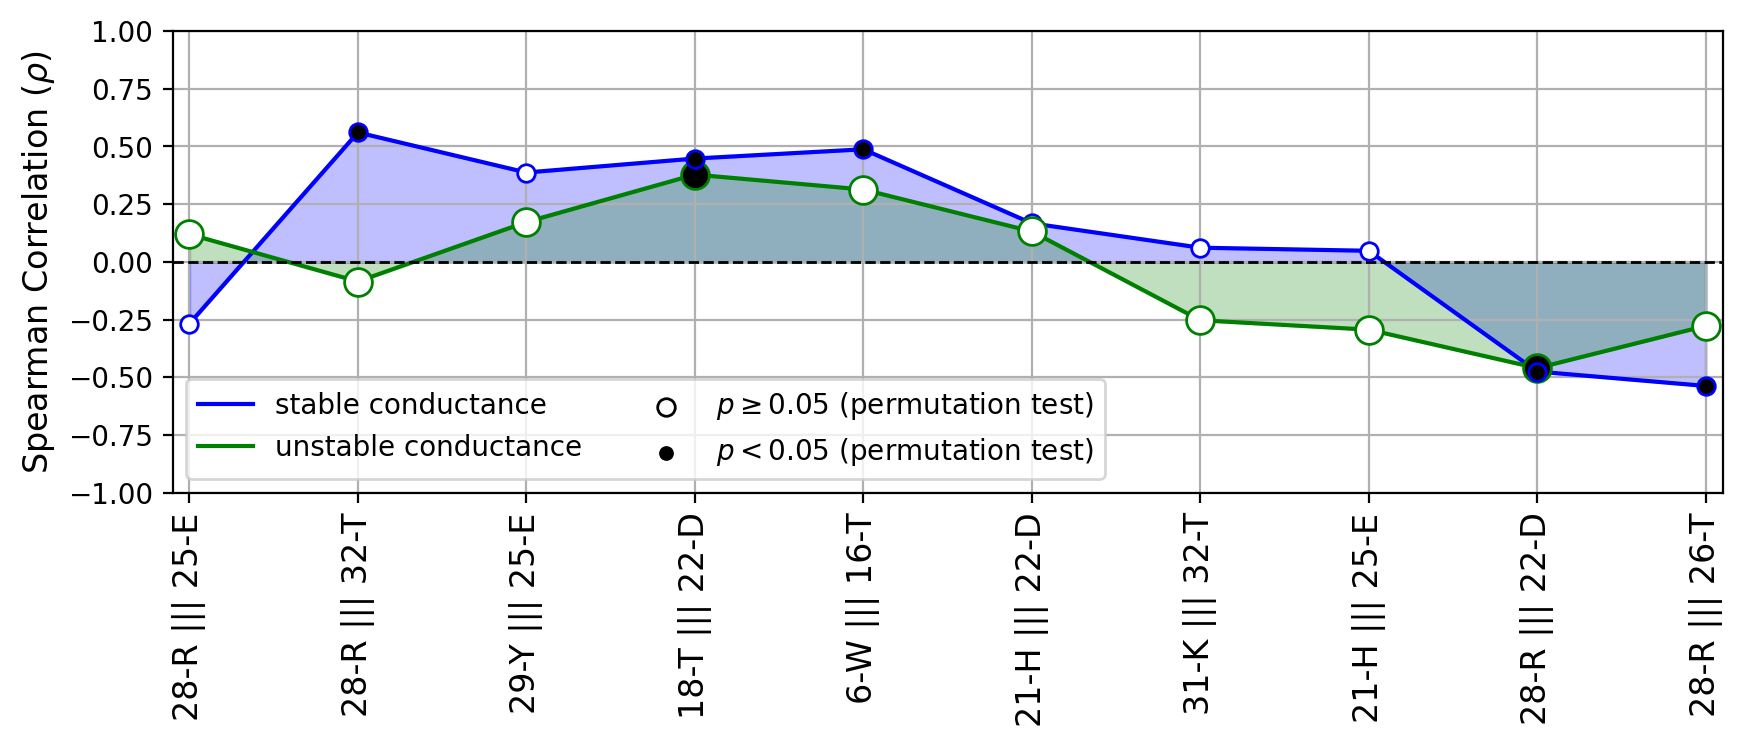

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10,3),sharex=True,dpi=200)

alpha=0.05

ax.plot(data_stable['corr'],color='blue',label='stable conductance')
ax.fill_between(x=range(len(data_stable['corr'])), y1=0, y2 = data_stable['corr'], color='blue',alpha=0.25)
for i,p in enumerate(data_stable['pvalue']):
    if p < alpha:
        ax.scatter(i, data_stable['corr'][i], marker='o',s=40,color='black',edgecolor='blue',alpha=1,zorder=20)
    else:
        ax.scatter(i, data_stable['corr'][i], marker='o',s=40,color='white',edgecolor='blue',alpha=1,zorder=20)

ax.plot(data_unstable['corr'],color='green',label='unstable conductance')
ax.fill_between(x=range(len(data_unstable['corr'])), y1=0, y2 = data_unstable['corr'], color='green',alpha=0.25)
for i,p in enumerate(data_unstable['pvalue']):
    if p < alpha:
        ax.scatter(i, data_unstable['corr'][i], marker='o',s=100,color='black',edgecolor='green',alpha=1,zorder=10)
    else:
        ax.scatter(i, data_unstable['corr'][i], marker='o',s=100,color='white',edgecolor='green',alpha=1,zorder=20)
        
ax.axhline(y=0,color='black',linestyle='--',lw=1)

aa_3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
         'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
         'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
         'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

labels = []
for hbond in hbonds_leads:    
    donor_resn, donor_resname = hbond[0].split("-")
    acceptor_resn, acceptor_resname = hbond[1].split("-")
    hbond_label = donor_resn+'-'+aa_3to1[donor_resname]+' ||| '+acceptor_resn+'-'+aa_3to1[acceptor_resname]
    labels.append(hbond_label)
    
ax.set_xticks(range(len(hbonds_leads)))
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='x', rotation=90)

ax.scatter([],[],label='$p \geq 0.05$ (permutation test)',marker='o',s=40,color='white',edgecolor='black',alpha=1)
ax.scatter([],[],label='$p < 0.05$ (permutation test)',marker='o',s=40,color='black',edgecolor='white',alpha=1)

ax.set_ylabel('Spearman Correlation ($\\rho$)',fontsize=12)

ax.set_xlim(-0.1,9.1)
ax.set_ylim(-1,1)
ax.legend(loc='lower left',ncols=2,fontsize=10)
ax.grid(True)

plt.show()

## Noncovalent Contacts

In [14]:
# Conductance
df_conductance_stable = pd.DataFrame(conductance_stable)
df_conductance_unstable = pd.DataFrame(conductance_unstable)

n_contacts = len(contacts_leads)
data_stable = {'corr':[],'pvalue':[]}
data_unstable = {'corr':[],'pvalue':[]}
for i, contact in enumerate(contacts_leads[:n_contacts]):
    contact = tuple(json.loads(contact))
    # dataframes
    df_contacts_stable = pd.DataFrame(contacts_stable[contact])
    df_contacts_unstable = pd.DataFrame(contacts_unstable[contact])
    
    # correlation results: stable conductance models
    x1 = df_conductance_stable.median()
    y1 = df_contacts_stable.median()
    c1 = stats.spearmanr(x1,y1)
    def statistic(x1):
        return stats.spearmanr(x1, y1).statistic
        
    res1_exact = stats.permutation_test((x1,),
                                       statistic,
                                       permutation_type='pairings')
    data_stable['corr'].append(c1.correlation); data_stable['pvalue'].append(res1_exact.pvalue)

    # correlation results: unstable conductance models
    x2 = df_conductance_unstable.median()
    y2 = df_contacts_unstable.median()
    c2 = stats.spearmanr(x2,y2)
    def statistic(x2):
        return stats.spearmanr(x2, y2).statistic
        
    res2_exact = stats.permutation_test((x2,),
                                       statistic,
                                       permutation_type='pairings')
    data_unstable['corr'].append(c2.correlation); data_unstable['pvalue'].append(res2_exact.pvalue)

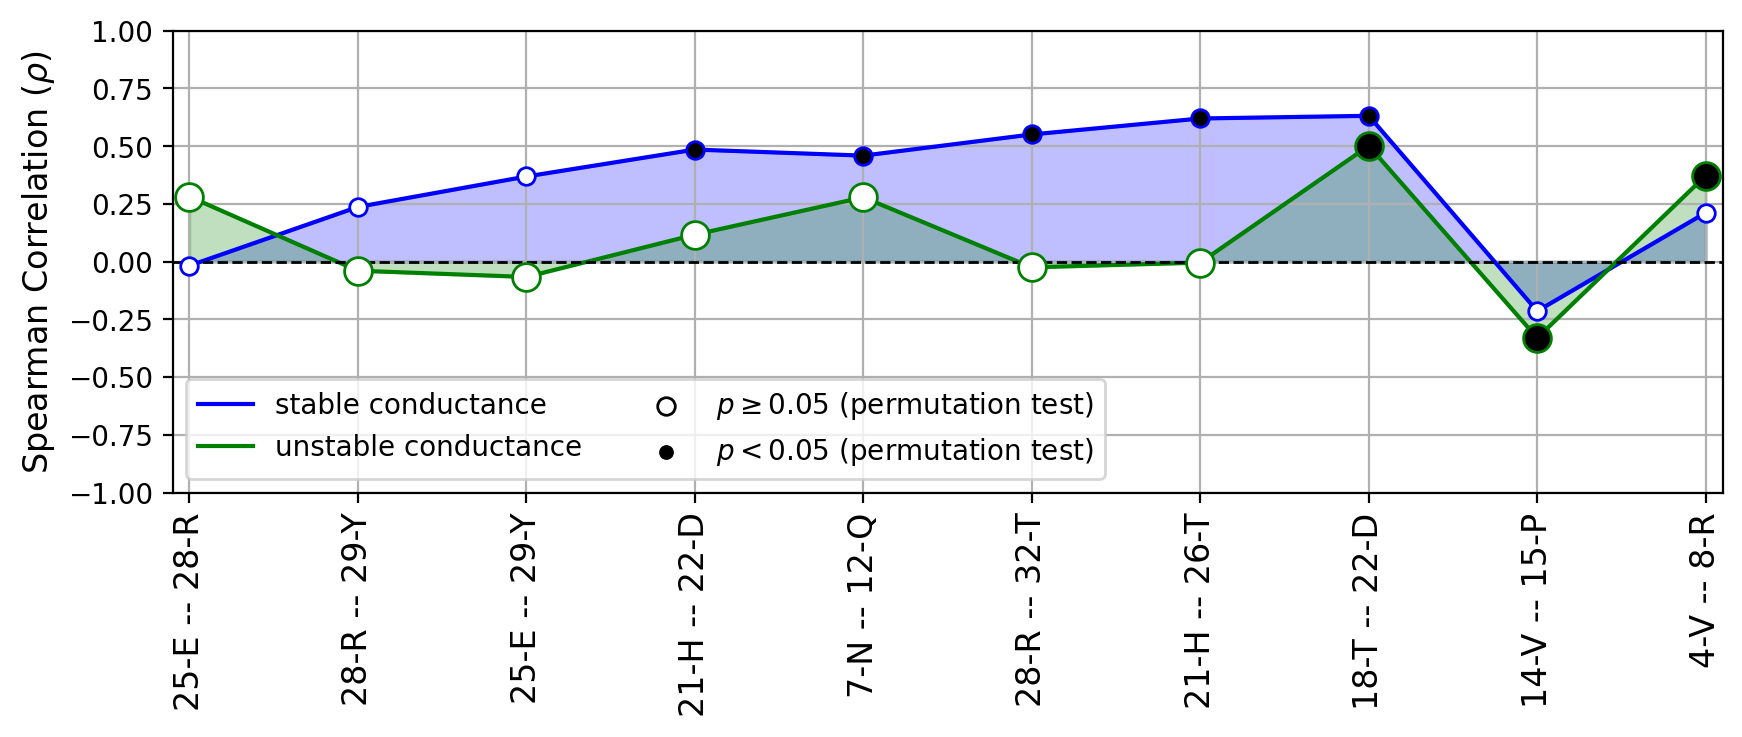

In [15]:
fig,ax = plt.subplots(1,1,figsize=(10,3),sharex=True,dpi=200)

alpha=0.05

ax.plot(data_stable['corr'],color='blue',label='stable conductance')
ax.fill_between(x=range(len(data_stable['corr'])), y1=0, y2 = data_stable['corr'], color='blue',alpha=0.25)
for i,p in enumerate(data_stable['pvalue']):
    if p < alpha:
        ax.scatter(i, data_stable['corr'][i], marker='o',s=40,color='black',edgecolor='blue',alpha=1,zorder=20)
    else:
        ax.scatter(i, data_stable['corr'][i], marker='o',s=40,color='white',edgecolor='blue',alpha=1,zorder=20)

ax.plot(data_unstable['corr'],color='green',label='unstable conductance')
ax.fill_between(x=range(len(data_unstable['corr'])), y1=0, y2 = data_unstable['corr'], color='green',alpha=0.25)
for i,p in enumerate(data_unstable['pvalue']):
    if p < alpha:
        ax.scatter(i, data_unstable['corr'][i], marker='o',s=100,color='black',edgecolor='green',alpha=1,zorder=10)
    else:
        ax.scatter(i, data_unstable['corr'][i], marker='o',s=100,color='white',edgecolor='green',alpha=1,zorder=20)
        
ax.axhline(y=0,color='black',linestyle='--',lw=1)

seq = 'APLVRWNRVISQLVPTITGVHDLTETVRYIKTWPN'

labels = []
for contact in contacts_leads:  
    contact = tuple(json.loads(contact))
    resn_A = contact[0]
    resn_B = contact[1]
    contact_label = str(resn_A)+'-'+seq[resn_A-1]+' -- '+str(resn_B)+'-'+seq[resn_B-1]
    labels.append(contact_label)
    
ax.set_xticks(range(len(contacts_leads)))
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='x', rotation=90)

ax.scatter([],[],label='$p \geq 0.05$ (permutation test)',marker='o',s=40,color='white',edgecolor='black',alpha=1)
ax.scatter([],[],label='$p < 0.05$ (permutation test)',marker='o',s=40,color='black',edgecolor='white',alpha=1)

ax.set_ylabel('Spearman Correlation ($\\rho$)',fontsize=12)

ax.set_xlim(-0.1,9.1)
ax.set_ylim(-1,1)
ax.legend(loc='lower left',ncols=2,fontsize=10)
ax.grid(True)

plt.show()

# Dominant interactions: Breakdown by conductance stability

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load H-bonds and Noncovalent dominant interactions data

In [30]:
df_dominant_hbonds = pd.read_pickle('data/df_md_dominant_hbonds.pickle')
df_dominant_contacts = pd.read_csv('data/df_md_dominant_contacts.csv')

Breakdown by model stability

In [48]:
filepath = 'data/Gpred_Rmin_timeseries_cleaned.pickle'
with open(filepath, 'rb') as fp:
    conductance_timeseries = pickle.load(fp)

In [49]:
X = conductance_timeseries

# Condition for stability
threshold = 0.09
f = lambda x: abs(x - x.mean()).mean() # absolute deviation

conductance_stable = {k:v for k,v in X.items() if f(v) <= threshold}
conductance_unstable = {k:v for k,v in X.items() if f(v) > threshold}

## Hydrogen bonds

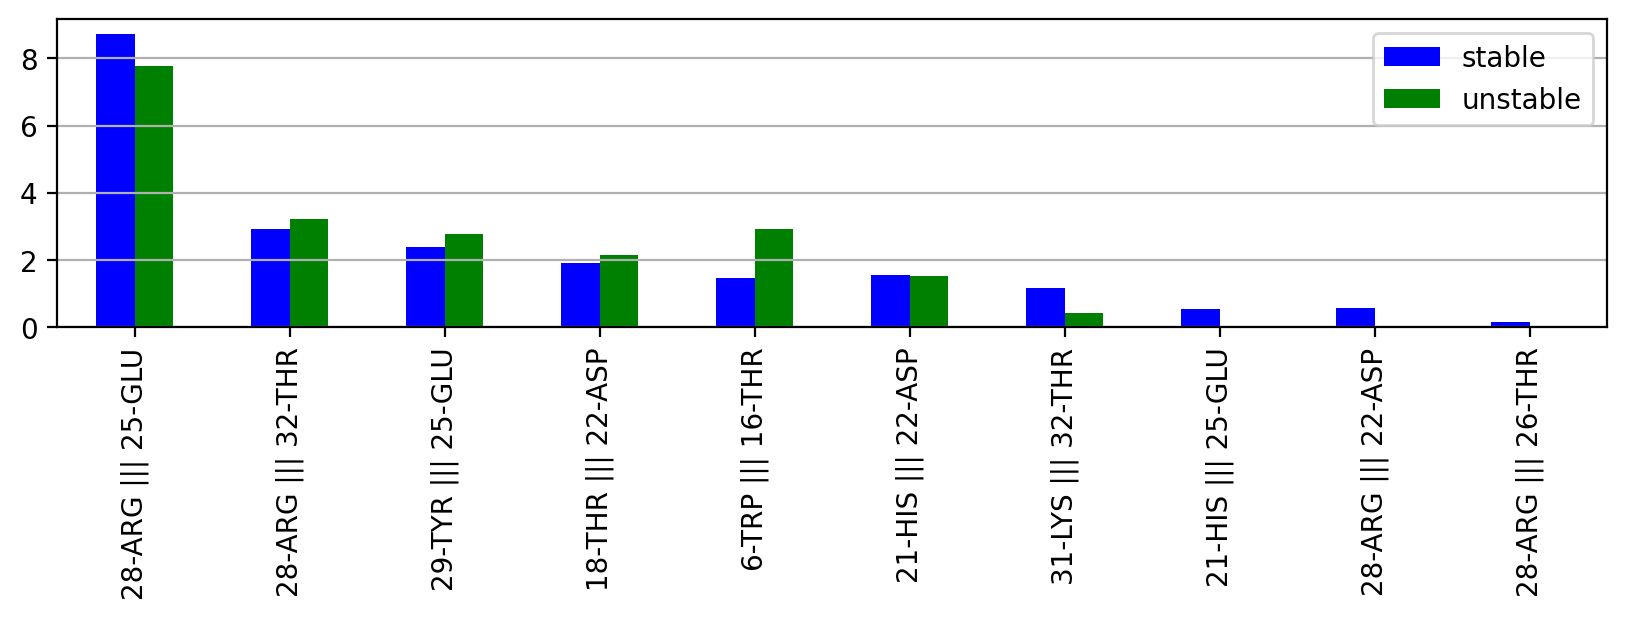

In [78]:
import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=(10,2),dpi=200)

data_stable = df_dominant_hbonds[conductance_stable.keys()].mean(axis=1)
data_unstable = df_dominant_hbonds[conductance_unstable.keys()].median(axis=1)
df = pd.concat([data_stable, data_unstable],axis=1)
df.columns = ['stable','unstable']

df.plot(kind='bar',color=['blue','green'],ax=ax)

ax.set_xticks(range(len(data_stable.index)))
hbonds_labels = [x[0]+' ||| '+x[1] for x in data_stable.index]
ax.set_xticklabels(hbonds_labels, rotation=90)

ax.yaxis.grid(True)
plt.show()

## Noncovalent contacts

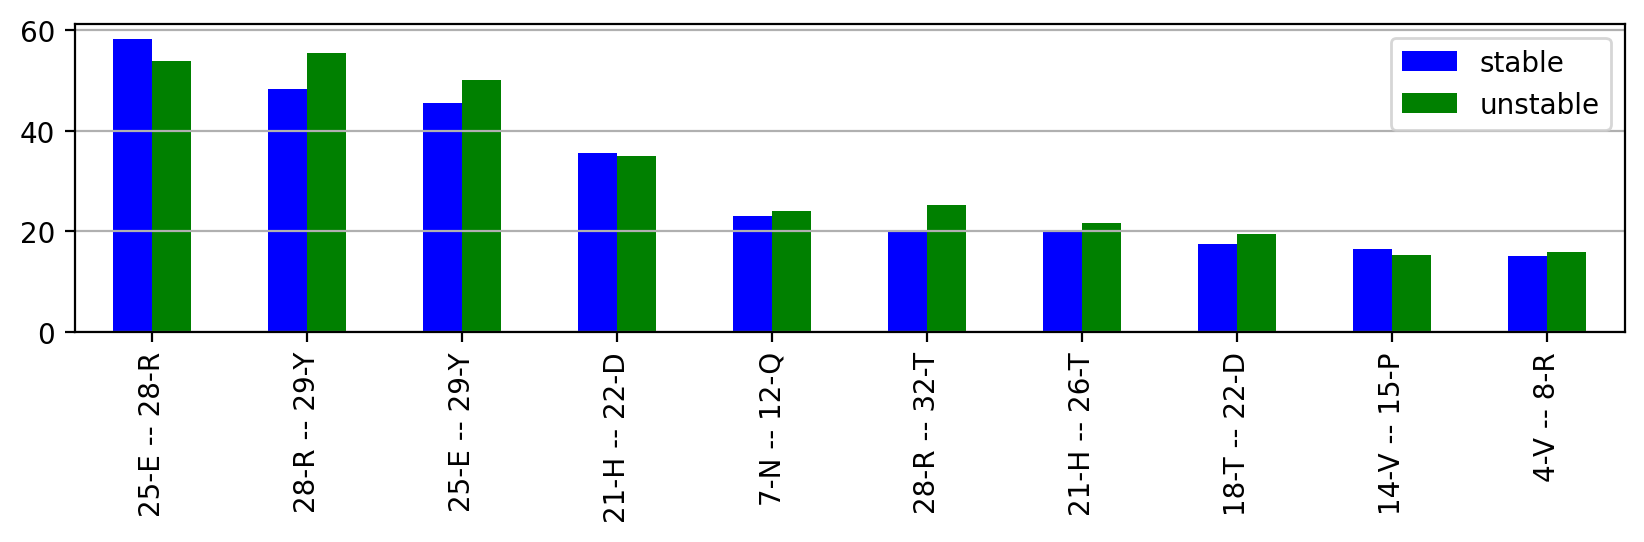

In [82]:
import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=(10,2),dpi=200)

data_stable = df_dominant_contacts[conductance_stable.keys()].mean(axis=1)
data_unstable = df_dominant_contacts[conductance_unstable.keys()].mean(axis=1)
df = pd.concat([data_stable, data_unstable],axis=1)
df.columns = ['stable','unstable']

df.plot(kind='bar',color=['blue','green'],ax=ax)

contacts_labels = []
f = lambda x:tuple(json.loads(x))
seq = 'APLVRWNRVISQLVPTITGVHDLTETVRYIKTWPN' # cWza sequence
for contact in data_stable.index:
    contact = f(contact)
    resn_A = contact[0]
    resn_B = contact[1]
    label = str(resn_A)+'-'+seq[resn_A-1]+' -- '+str(resn_B)+'-'+seq[resn_B-1]
    contacts_labels.append(label)

ax.set_xticklabels(contacts_labels, rotation=90)
ax.yaxis.grid(True)

plt.show()